## Дипломная работа

### Прогнозирование продаж фармдистрибьютора

In [98]:
# необходимые библиотеки
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from arch import arch_model

In [99]:
# данные в тыс руб.
df = pd.read_excel("Data.xls")
df.head()

,date,value
0,2019-01-03,515757.63689
1,2019-01-04,513952.19998
2,2019-01-05,3552.93217
3,2019-01-06,26971.21157
4,2019-01-07,0.00000


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    910 non-null    datetime64[ns]
 1   value   910 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.3 KB


In [101]:
# преобразуем и посмотрим статистику 

In [102]:
df.value = round(df.value)
df.value = df.value.astype(np.int32)

In [103]:
df.describe()

,value
count,9.100000e+02
mean,6.506428e+05
std,4.115450e+05
min,0.000000e+00
25%,2.267648e+05
50%,7.358910e+05
75%,9.629105e+05
max,1.661629e+06


In [104]:
# дополнительные функции

In [105]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh', title='Original'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(title)

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
        plt.show()
    return

In [106]:
# посмотрим на тест Дики-Фуллера и графики

Results of Dickey-Fuller Test:
Test Statistic                  -3.967059
p-value                          0.001593
Lags Used                       20.000000
Number of Observations Used    889.000000
Critical Value (1%)             -3.437727
Critical Value (5%)             -2.864797
Critical Value (10%)            -2.568504
dtype: float64


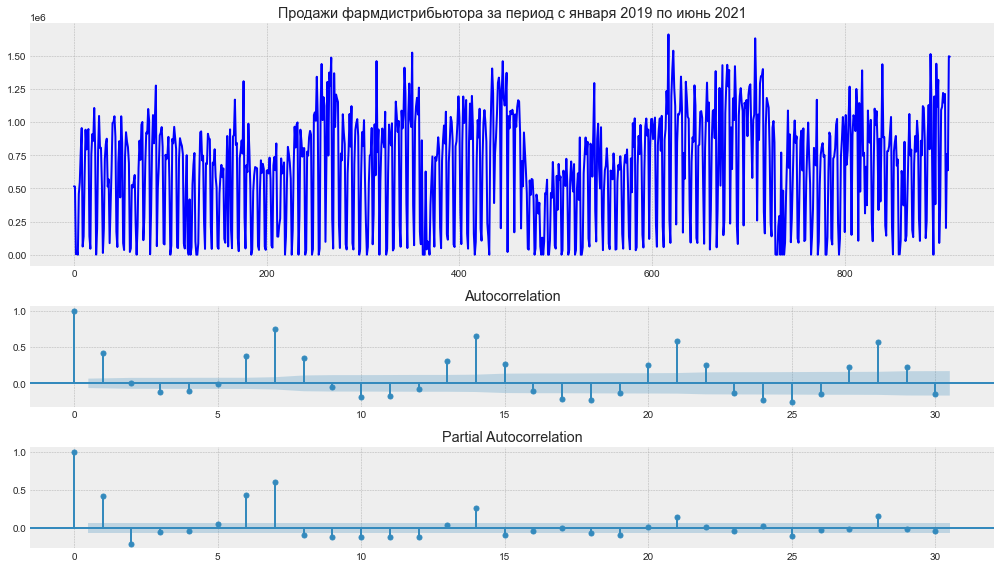

In [107]:
series = df.value
tsplot(series, title="Продажи фармдистрибьютора за период с января 2019 по июнь 2021")

In [108]:
# p-value отвергает гипотезу о нестационарности ряда. Ряд стационарен
# На графике нет тренда и цикличности, но есть сезонность. 

# Если бы была сильная дисперсия мы бы нормализовали ее при помощи преобразования Бокса-Кокса, например  boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                 -21.030822
p-value                          0.000000
Lags Used                       21.000000
Number of Observations Used    881.000000
Critical Value (1%)             -3.437794
Critical Value (5%)             -2.864826
Critical Value (10%)            -2.568520
dtype: float64


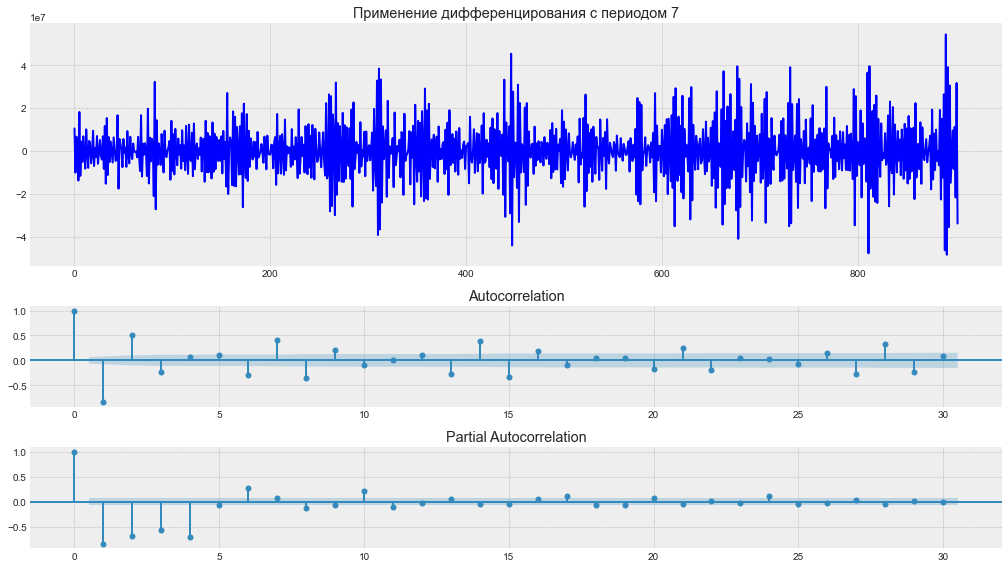

In [109]:
# Можно убрать сезонность дифференцированием
series = np.diff(series, 7)
tsplot(series, title="Применение дифференцирования с периодом 7")

Results of Dickey-Fuller Test:
Test Statistic                 -28.722483
p-value                          0.000000
Lags Used                        1.000000
Number of Observations Used    894.000000
Critical Value (1%)             -3.437686
Critical Value (5%)             -2.864778
Critical Value (10%)            -2.568494
dtype: float64


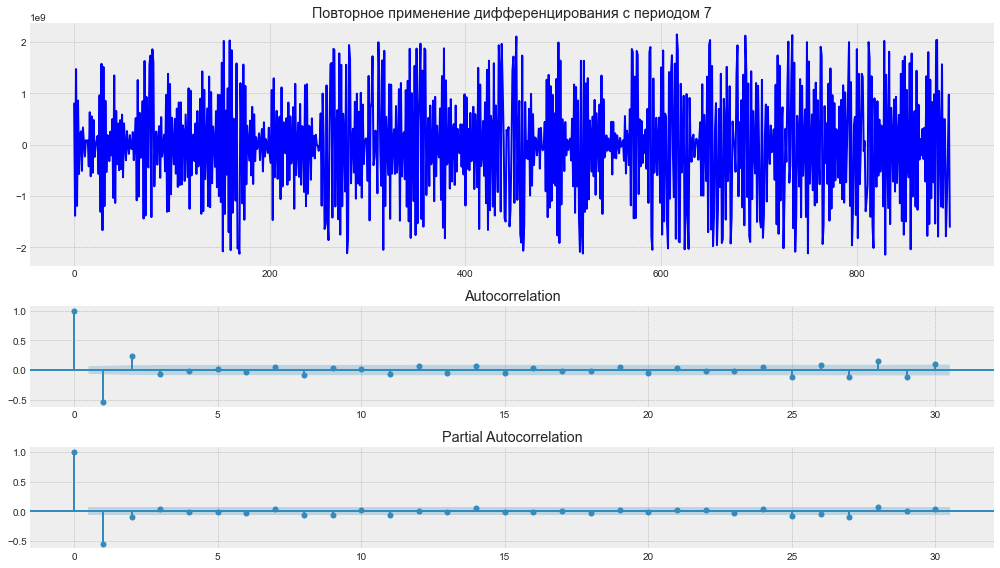

In [110]:
series = np.diff(series, 7)
tsplot(series, title="Повторное применение дифференцирования с периодом 7")

In [111]:
# для моделей не требуется предобработка данных, поэтому возьмем первоначальный ряд
series = df.value

In [112]:
# SARIMAX

In [113]:
# разделим на тренировочные и тестовые данные
len(series)

910

In [114]:
train_series = series[:880]
test_series = series[880:]

In [115]:
len(test_series)

30

In [116]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

In [117]:
# подберем наилучшие параметры для модели. На графике видно, что период сезонности равен 7, этот параметр подбирать не будем

In [118]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [119]:
best_aic = np.inf 
best_order = None
best_seasonal = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(series,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            tmp_aic = results.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = param
                best_seasonal = param_seasonal

        except: 
            continue
            
print('SARIMAX{}x{}7 - AIC:{}'.format(best_order,param_seasonal,best_aic))

SARIMAX(1, 0, 1)x(1, 1, 1, 7)7 - AIC:24709.41868324956


In [120]:
# подставим в модель найденные параметры, обучим на тренировочной выборке

In [121]:
mod = SARIMAX(train_series,
            order=(1, 0, 1),
            seasonal_order=(1, 1, 1, 7),
            enforce_stationarity=True,
            enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9372      0.028     33.063      0.000       0.882       0.993
ma.L1         -0.7220      0.049    -14.708      0.000      -0.818      -0.626
ar.S.L7        0.2086      0.048      4.367      0.000       0.115       0.302
ma.S.L7       -0.9680      0.019    -50.387      0.000      -1.006      -0.930
sigma2      7.859e+10   4.28e-14   1.84e+24      0.000    7.86e+10    7.86e+10


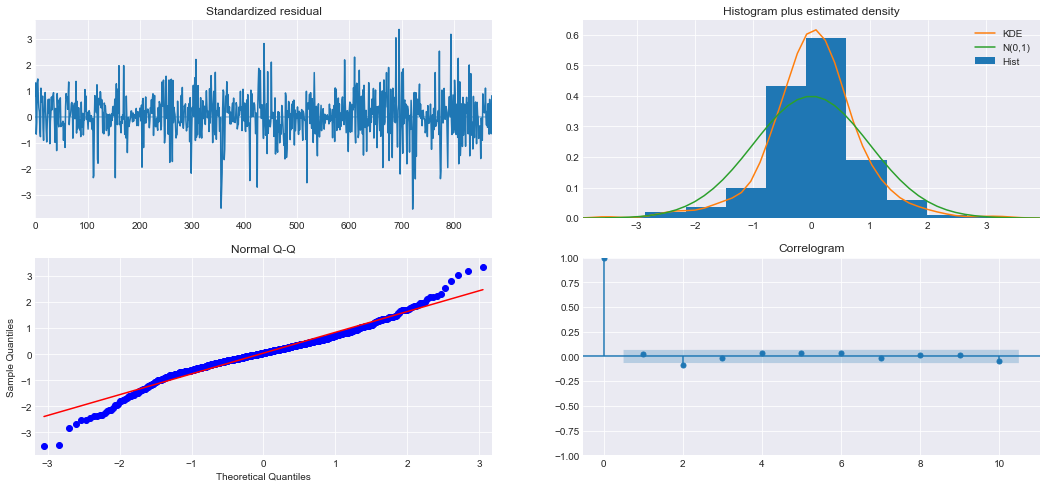

In [122]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [123]:
# предсказываем 30 значений
pred = results.forecast(steps=30)

In [124]:
# посчитаем метрики качества предсказания
print(f'RMSE: {(np.sqrt(mean_squared_error(test_series, pred))):.0f}')

RMSE: 322507


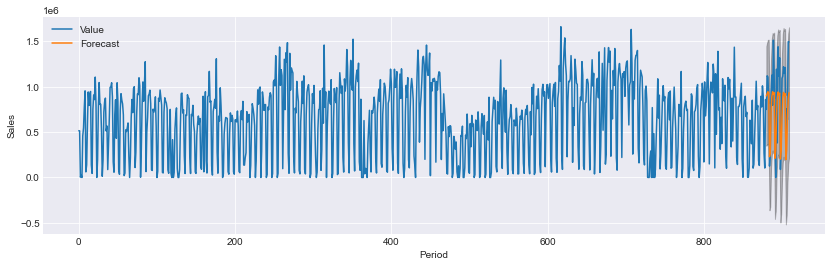

In [125]:
pred_uc = results.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = series.plot(label='Value', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Period')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [126]:
# LSTM

In [127]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [160]:
dataset = pd.read_excel("Data.xls", usecols=[1])

In [161]:
# нормализуем данные с помощью функции MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [162]:
# разделим данные на тестовые и тренинровочные
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print('Тренировочная выборка:',len(train), 'Тестовая выборка:', len(test))

Тренировочная выборка: 728 Тестовая выборка: 182


In [163]:
# преобразуем массив значений в матрицу данных 
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [164]:
# изменим X=t и Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [165]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [166]:
# создадим и обучим модель LSTM
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
726/726 - 1s - loss: 0.0672
Epoch 2/100
726/726 - 0s - loss: 0.0516
Epoch 3/100
726/726 - 0s - loss: 0.0513
Epoch 4/100
726/726 - 0s - loss: 0.0509
Epoch 5/100
726/726 - 0s - loss: 0.0508
Epoch 6/100
726/726 - 0s - loss: 0.0509
Epoch 7/100
726/726 - 0s - loss: 0.0508
Epoch 8/100
726/726 - 0s - loss: 0.0508
Epoch 9/100
726/726 - 0s - loss: 0.0505
Epoch 10/100
726/726 - 0s - loss: 0.0508
Epoch 11/100
726/726 - 0s - loss: 0.0509
Epoch 12/100
726/726 - 0s - loss: 0.0509
Epoch 13/100
726/726 - 0s - loss: 0.0510
Epoch 14/100
726/726 - 0s - loss: 0.0507
Epoch 15/100
726/726 - 0s - loss: 0.0507
Epoch 16/100
726/726 - 0s - loss: 0.0506
Epoch 17/100
726/726 - 0s - loss: 0.0505
Epoch 18/100
726/726 - 0s - loss: 0.0509
Epoch 19/100
726/726 - 0s - loss: 0.0507
Epoch 20/100
726/726 - 0s - loss: 0.0508
Epoch 21/100
726/726 - 0s - loss: 0.0505
Epoch 22/100
726/726 - 0s - loss: 0.0508
Epoch 23/100
726/726 - 0s - loss: 0.0508
Epoch 24/100
726/726 - 0s - loss: 0.0509
Epoch 25/100
726/726 - 0s

In [167]:
# предсказания
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# инвертируем предсказания
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# посчитаем метрику качества
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 373219.50 RMSE
Test Score: 377256.63 RMSE


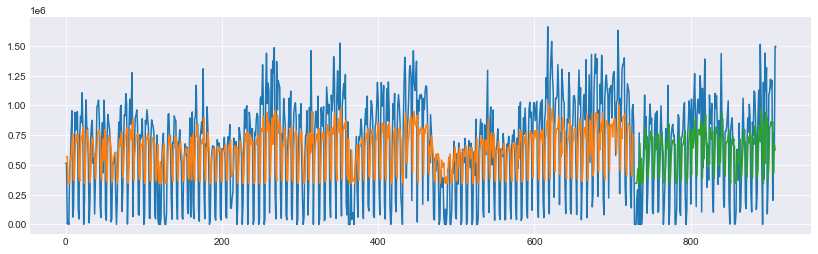

In [168]:
# покажем на графике полученные результаты
plt.figure(figsize=(14, 4))
 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()